✅ BERT is used in this project (on a subset of the train/test data as advised).

# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
display(df_reviews.info())
df_reviews

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

None

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


## EDA

Let's check the number of movies and reviews over years.

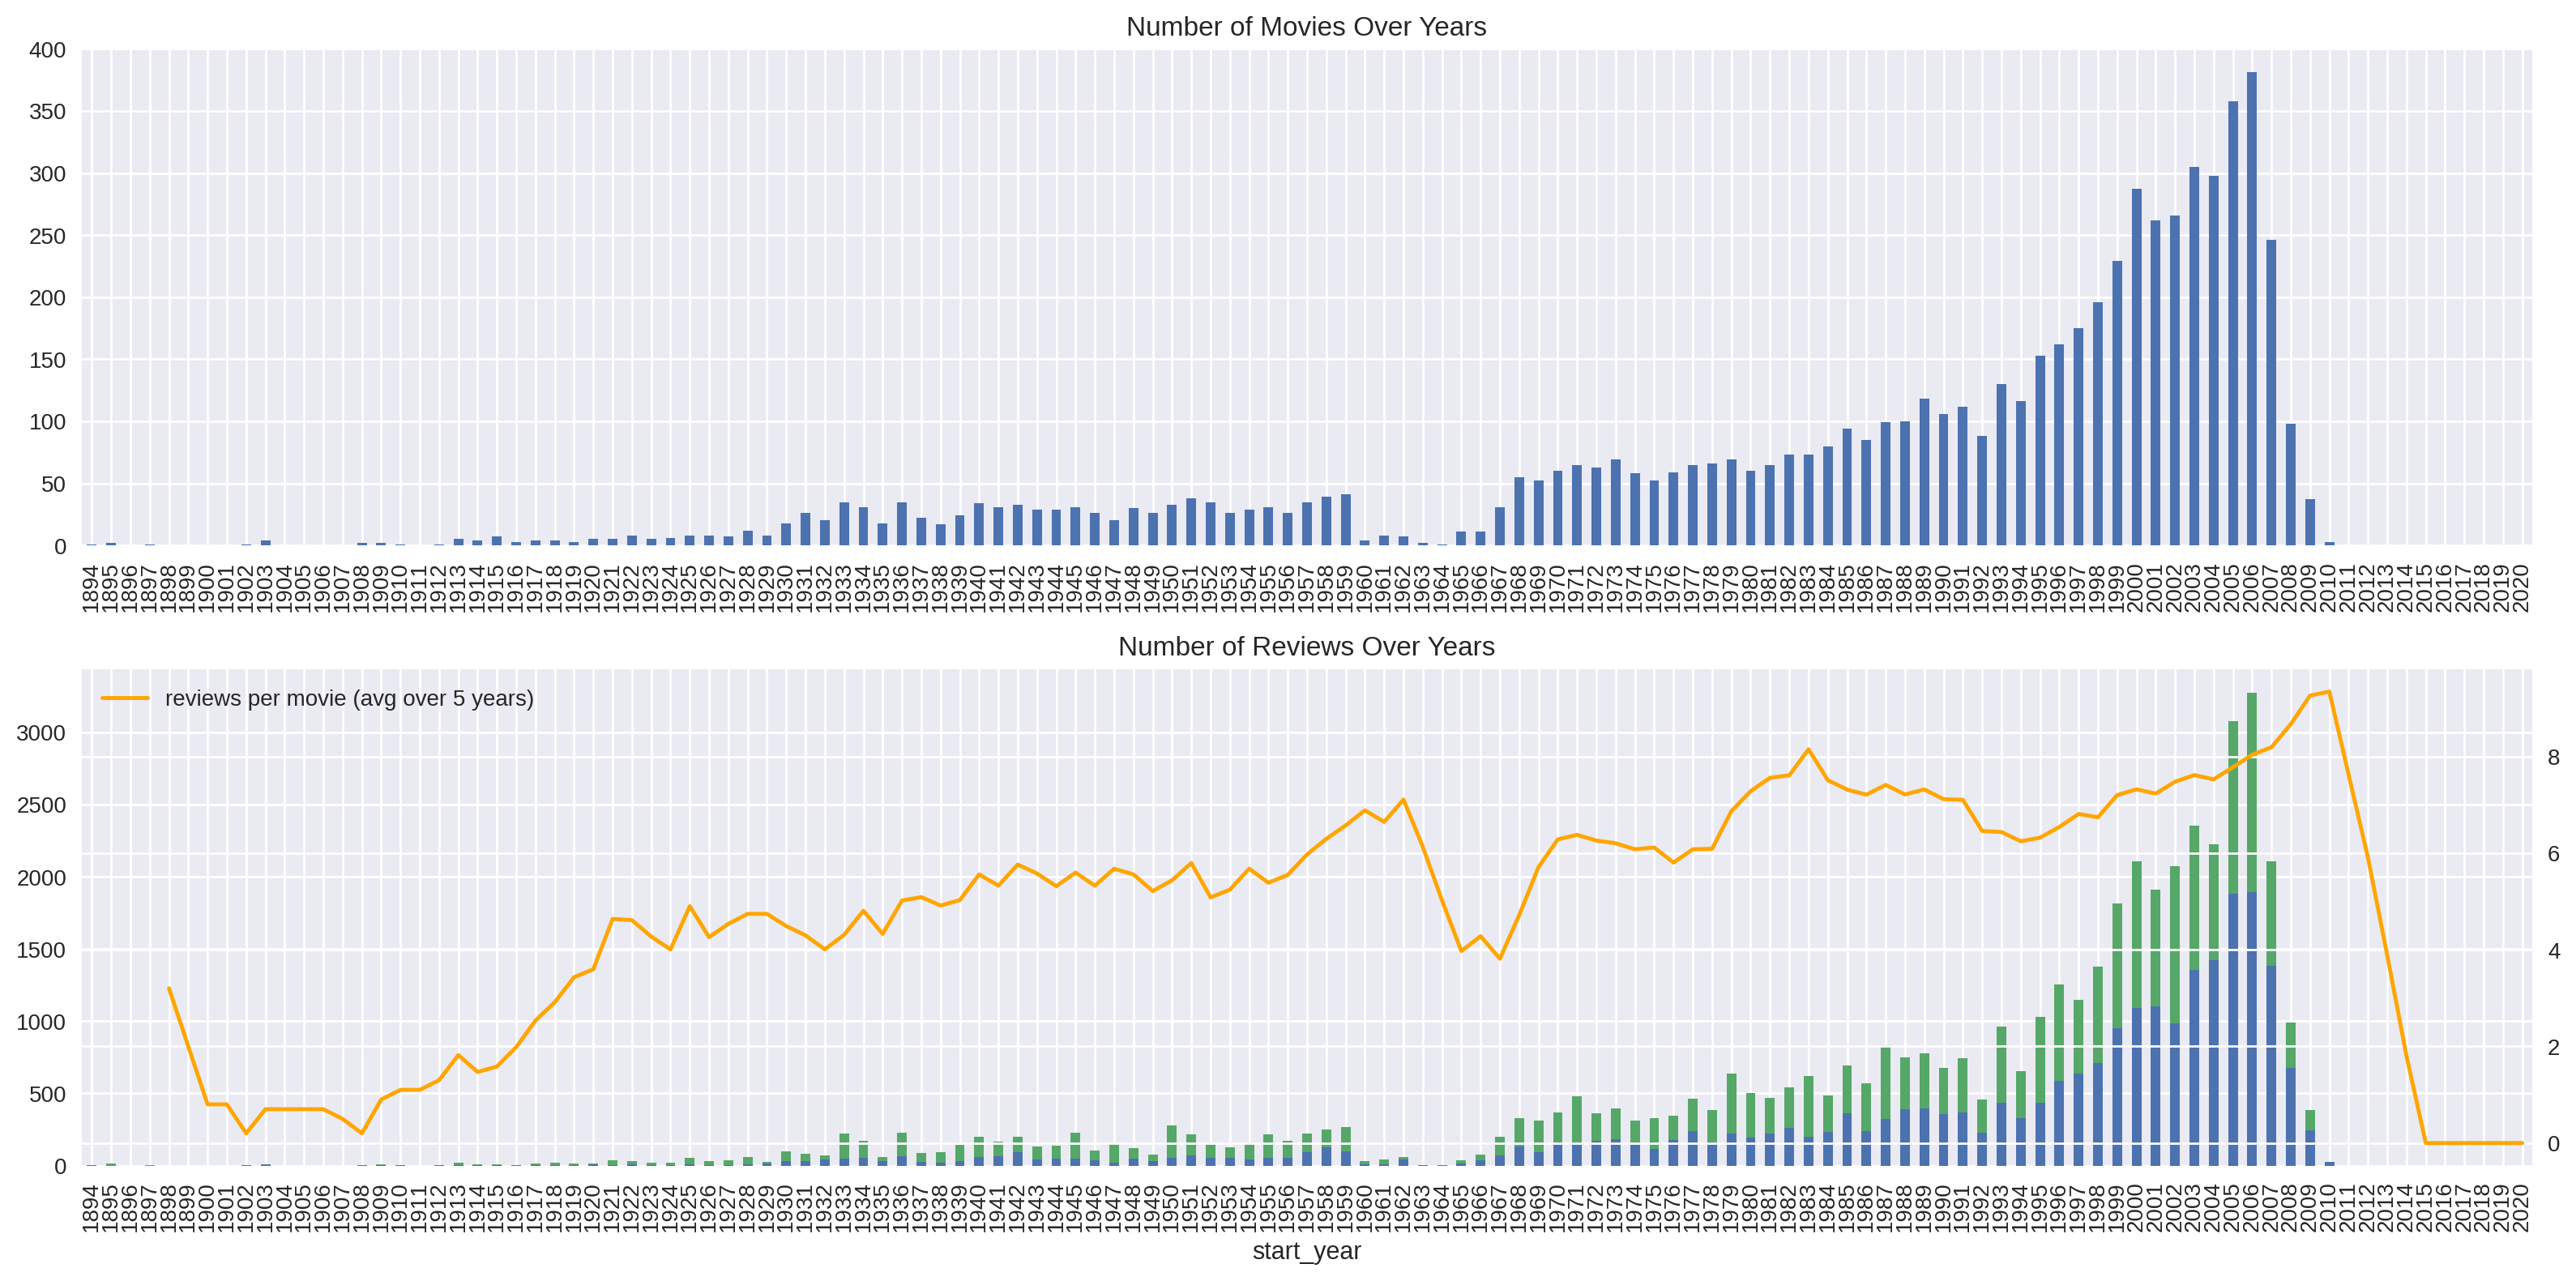

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

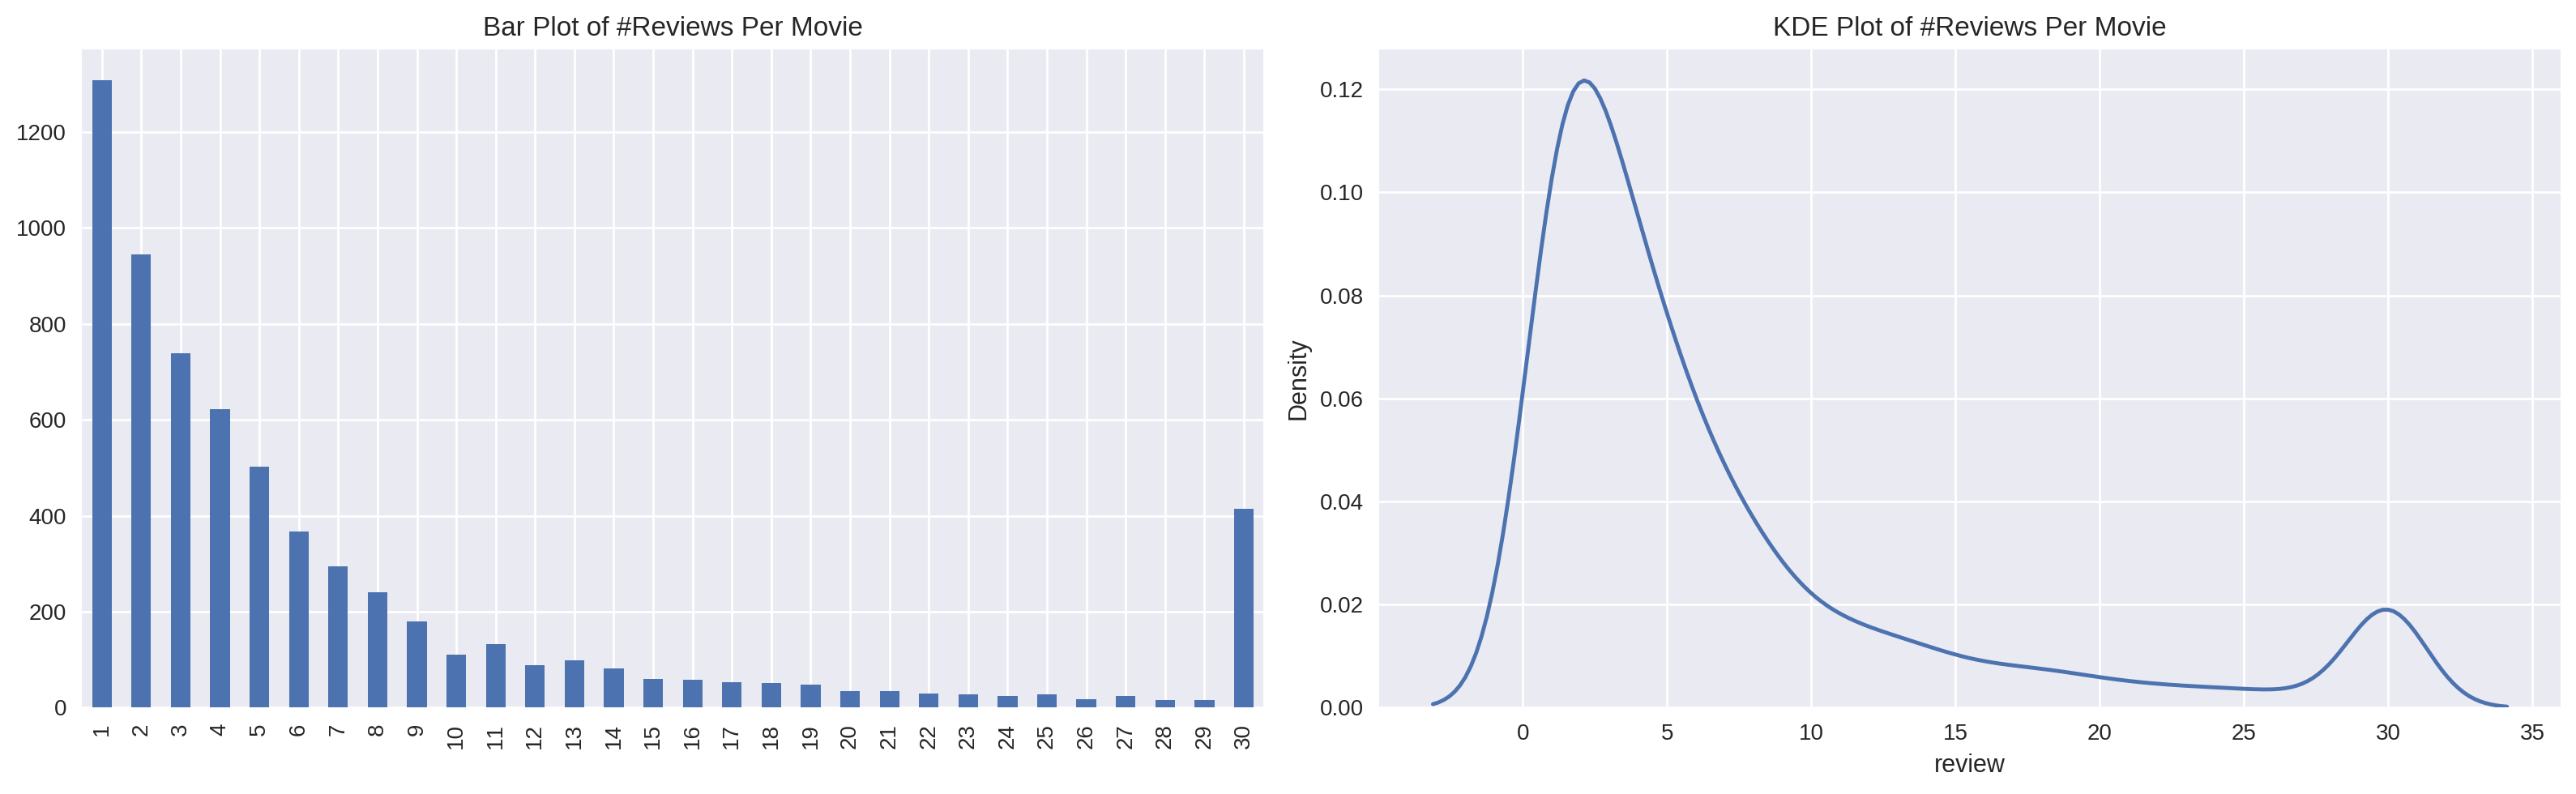

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

The data look good overall. There are a few problems, such as the end_year and runtime_minutes columns being incorrectly typed as strings and two missing values in the average_rating and votes columns, but I will ignore those because I do not expect to use them. The number of movies reviewed increased over time, peaking in 2006 and quickly declining to zero within a few years. The number of reviews per movie is sharply skewed right, resembling a log-normal or negative binomial distribution. The largest value (30 reviews) is unexpectedly frequent, perhaps indicating the truncation of additional reviews for each movie. 

Most of the features (e.g., title, start_year, runtime_minutes, genre) are irrelevant to the task of classifying positive and negative reviews. Certain years or genres might happen to correlate with reviews, but since the project is about semantic analysis of text, I will exclude those external factors. The rating, average_rating, and votes features almost certainly do predict review valence, but I will exclude them to rely on the text alone. 

In [8]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

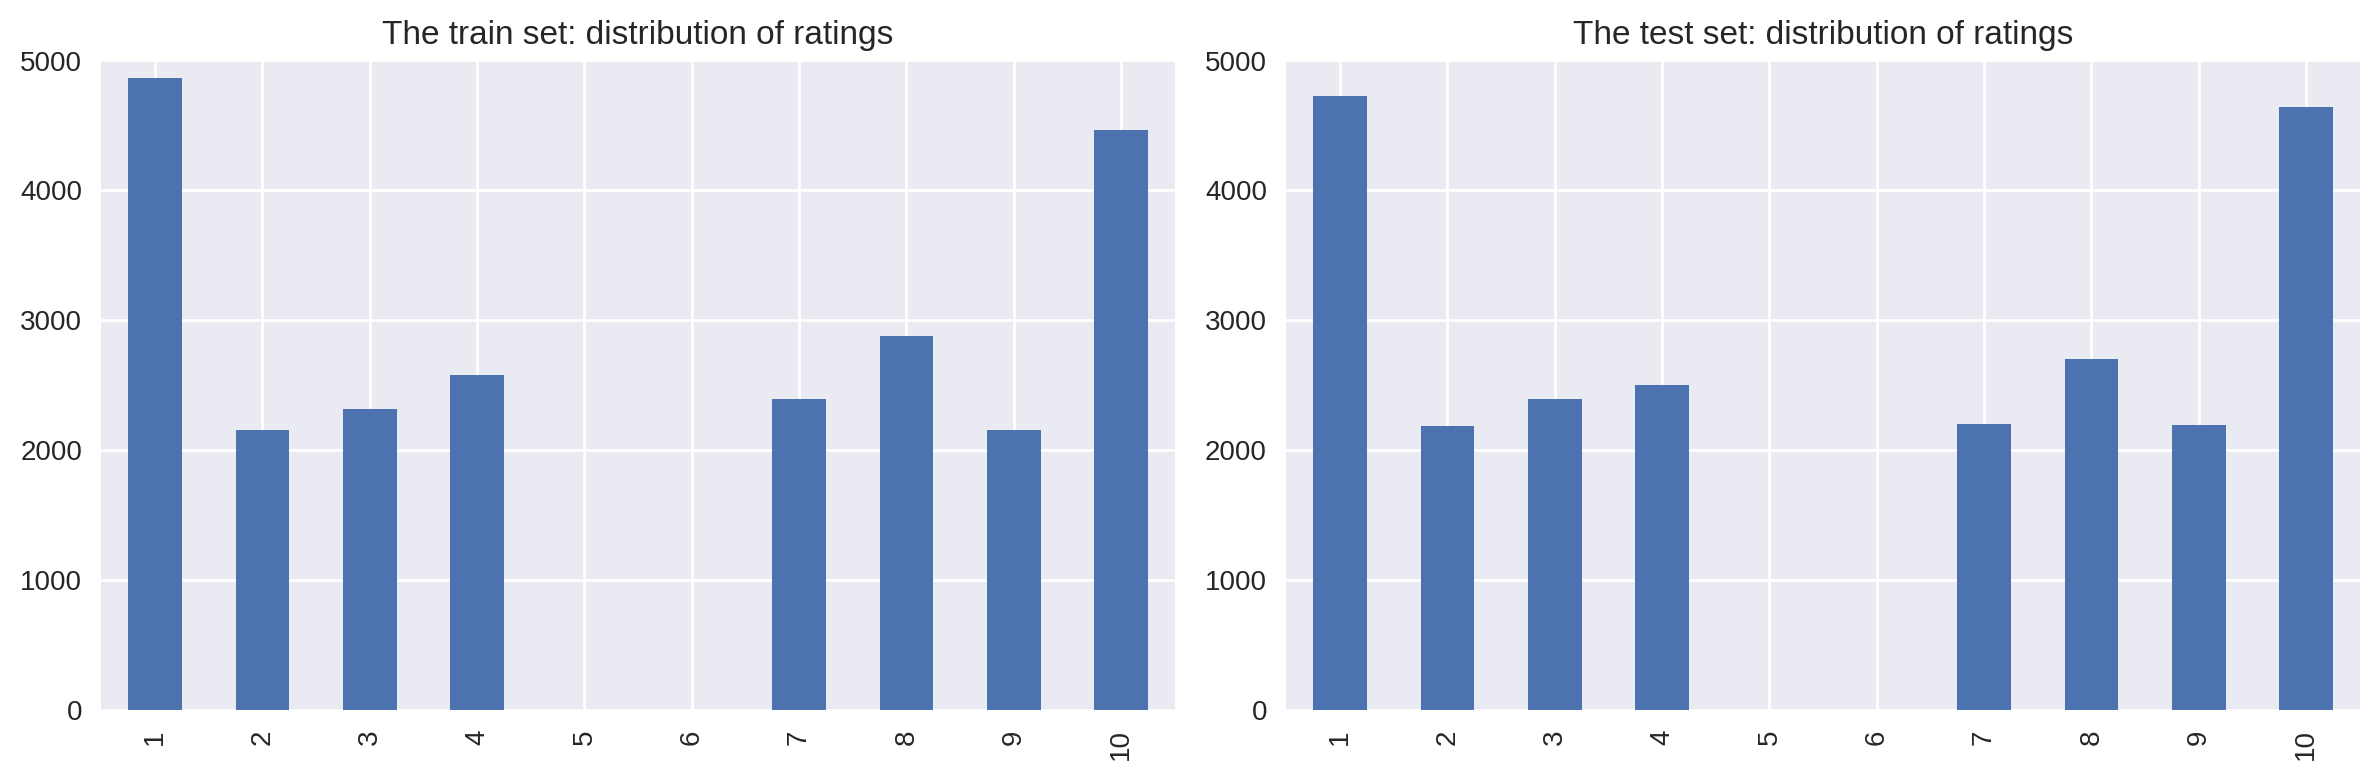

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


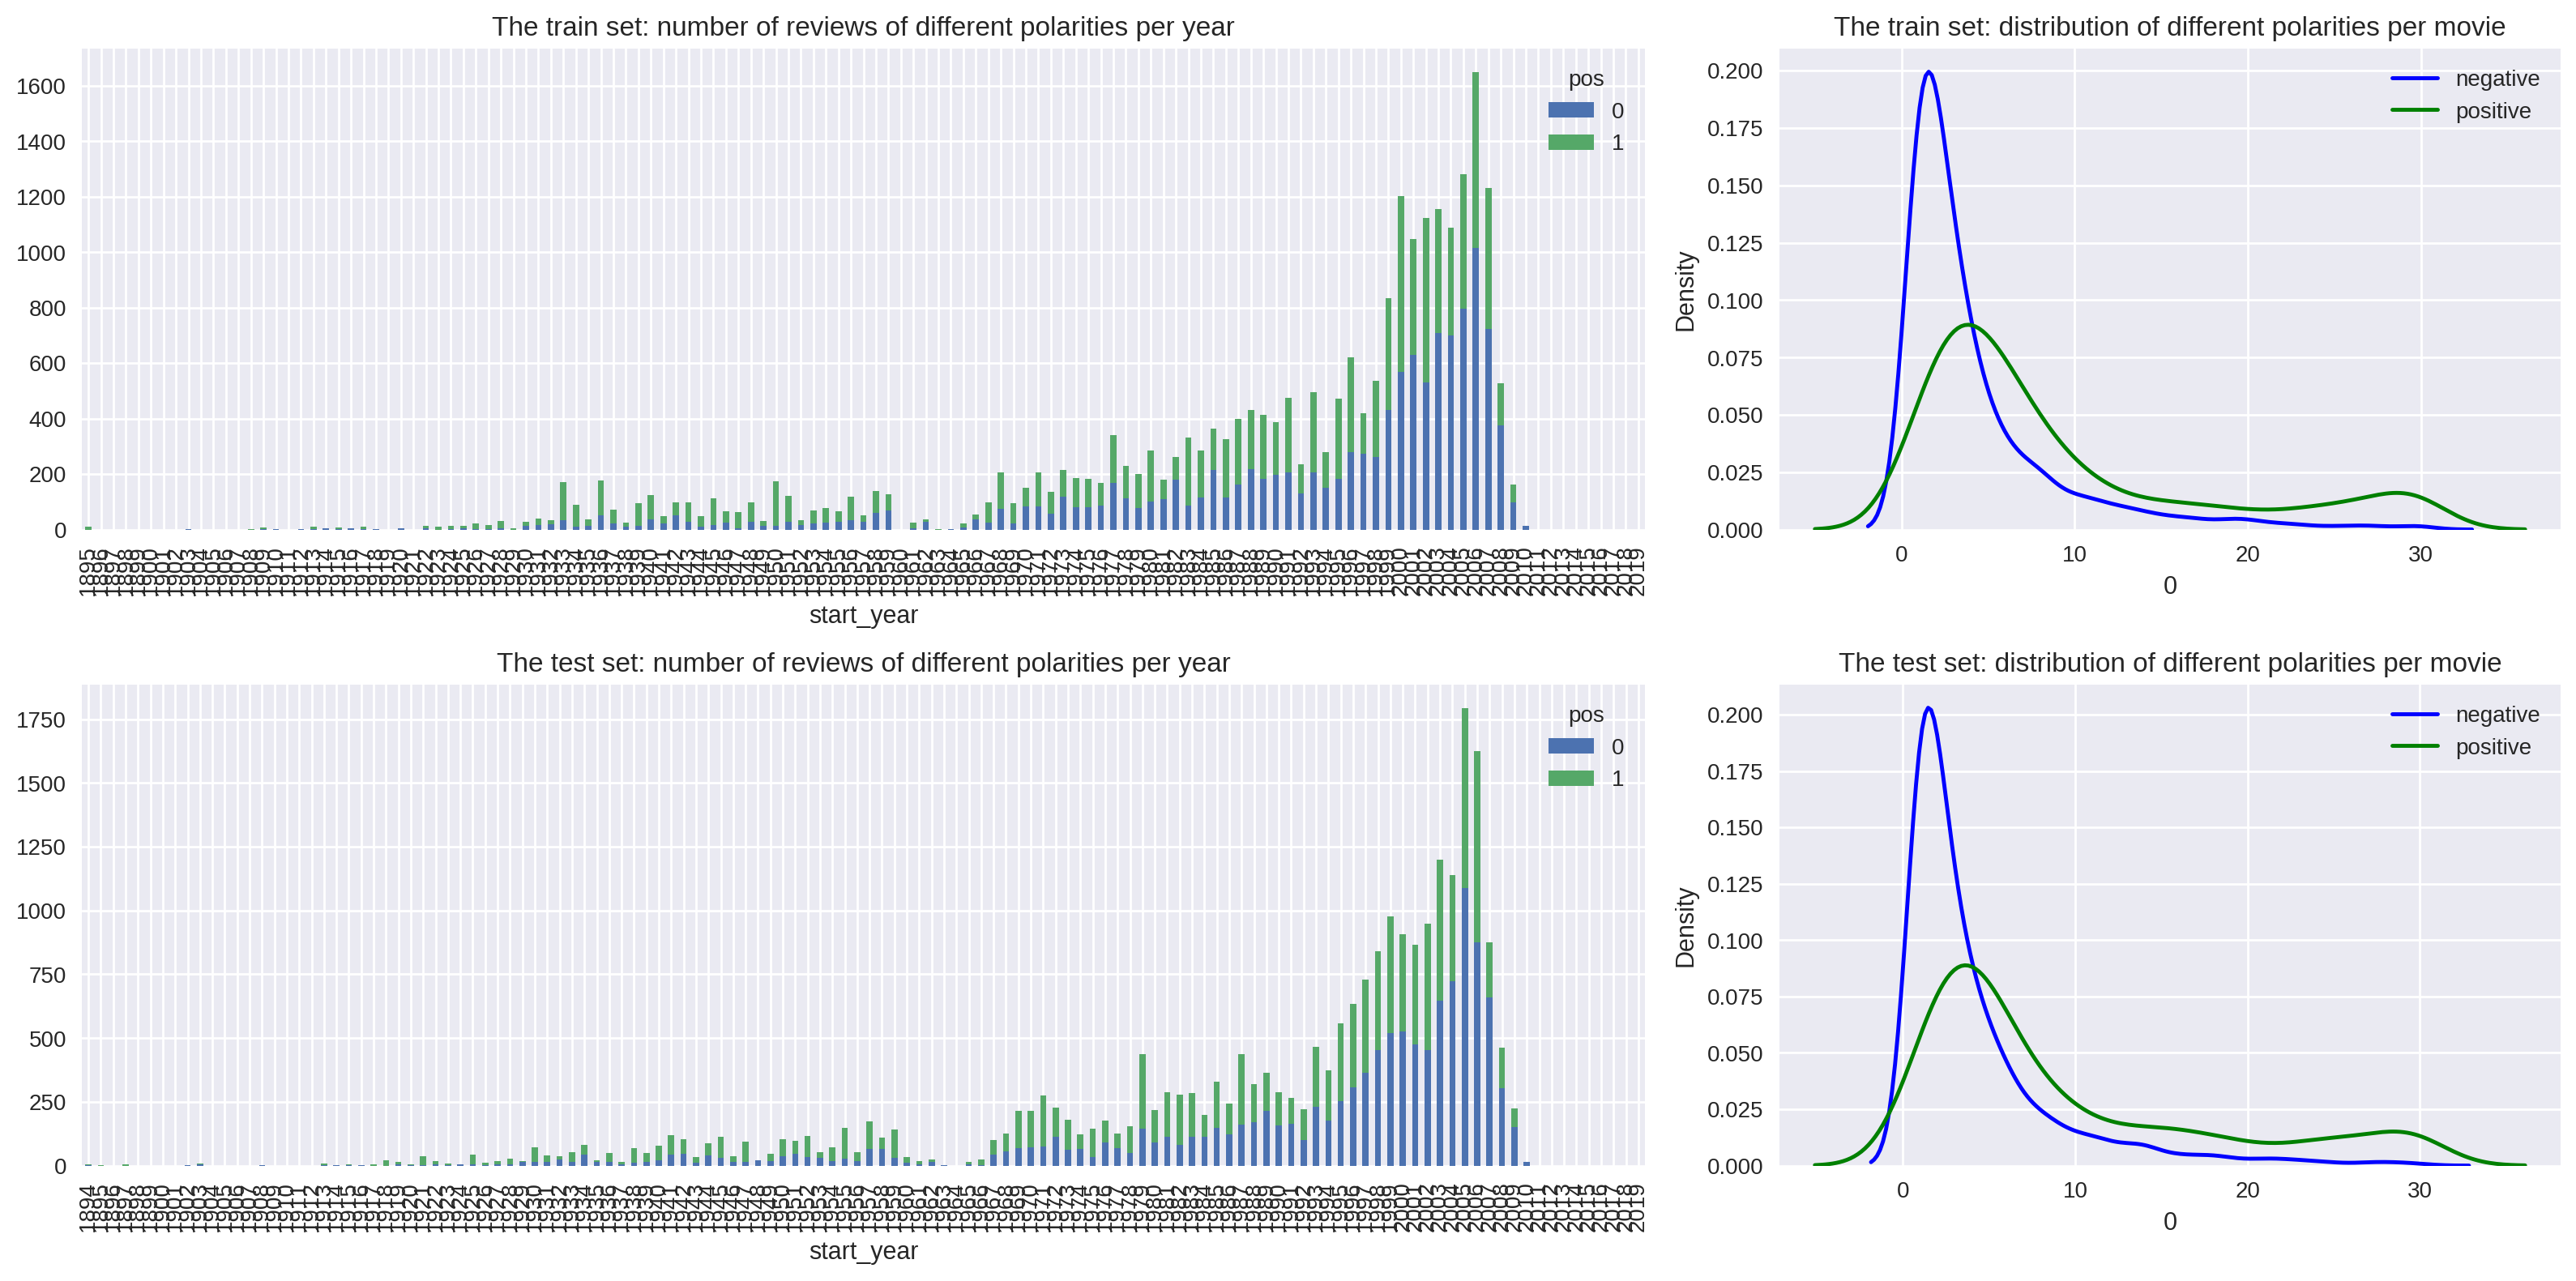

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

The ratings feature (from which the pos feature was presumably derived) has a symmetrical distribution with the extreme values (1 and 10) most frequent and middle values (5 and 6) unrepresented. Distributions of both positive and negative reviews are skewed right but the latter more extensively. 

The target feature (pos) has almost no class imbalance (23,715 zeros vs. 23,616 ones). Plots show all relevant distributions (including total ratings, ratings over time, and number of ratings per movie) to be indistinguishable between training and testing datasets. The data appear to be well-suited for modeling without further modification. 

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [11]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [12]:
df_reviews['review_norm'] = (df_reviews['review'].str.lower().str.replace(r"[^a-zA-Z']", ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip())

df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47331, dtype: object

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [13]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Working with models

### Model 0 - Constant

In [14]:
from sklearn.dummy import DummyClassifier

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


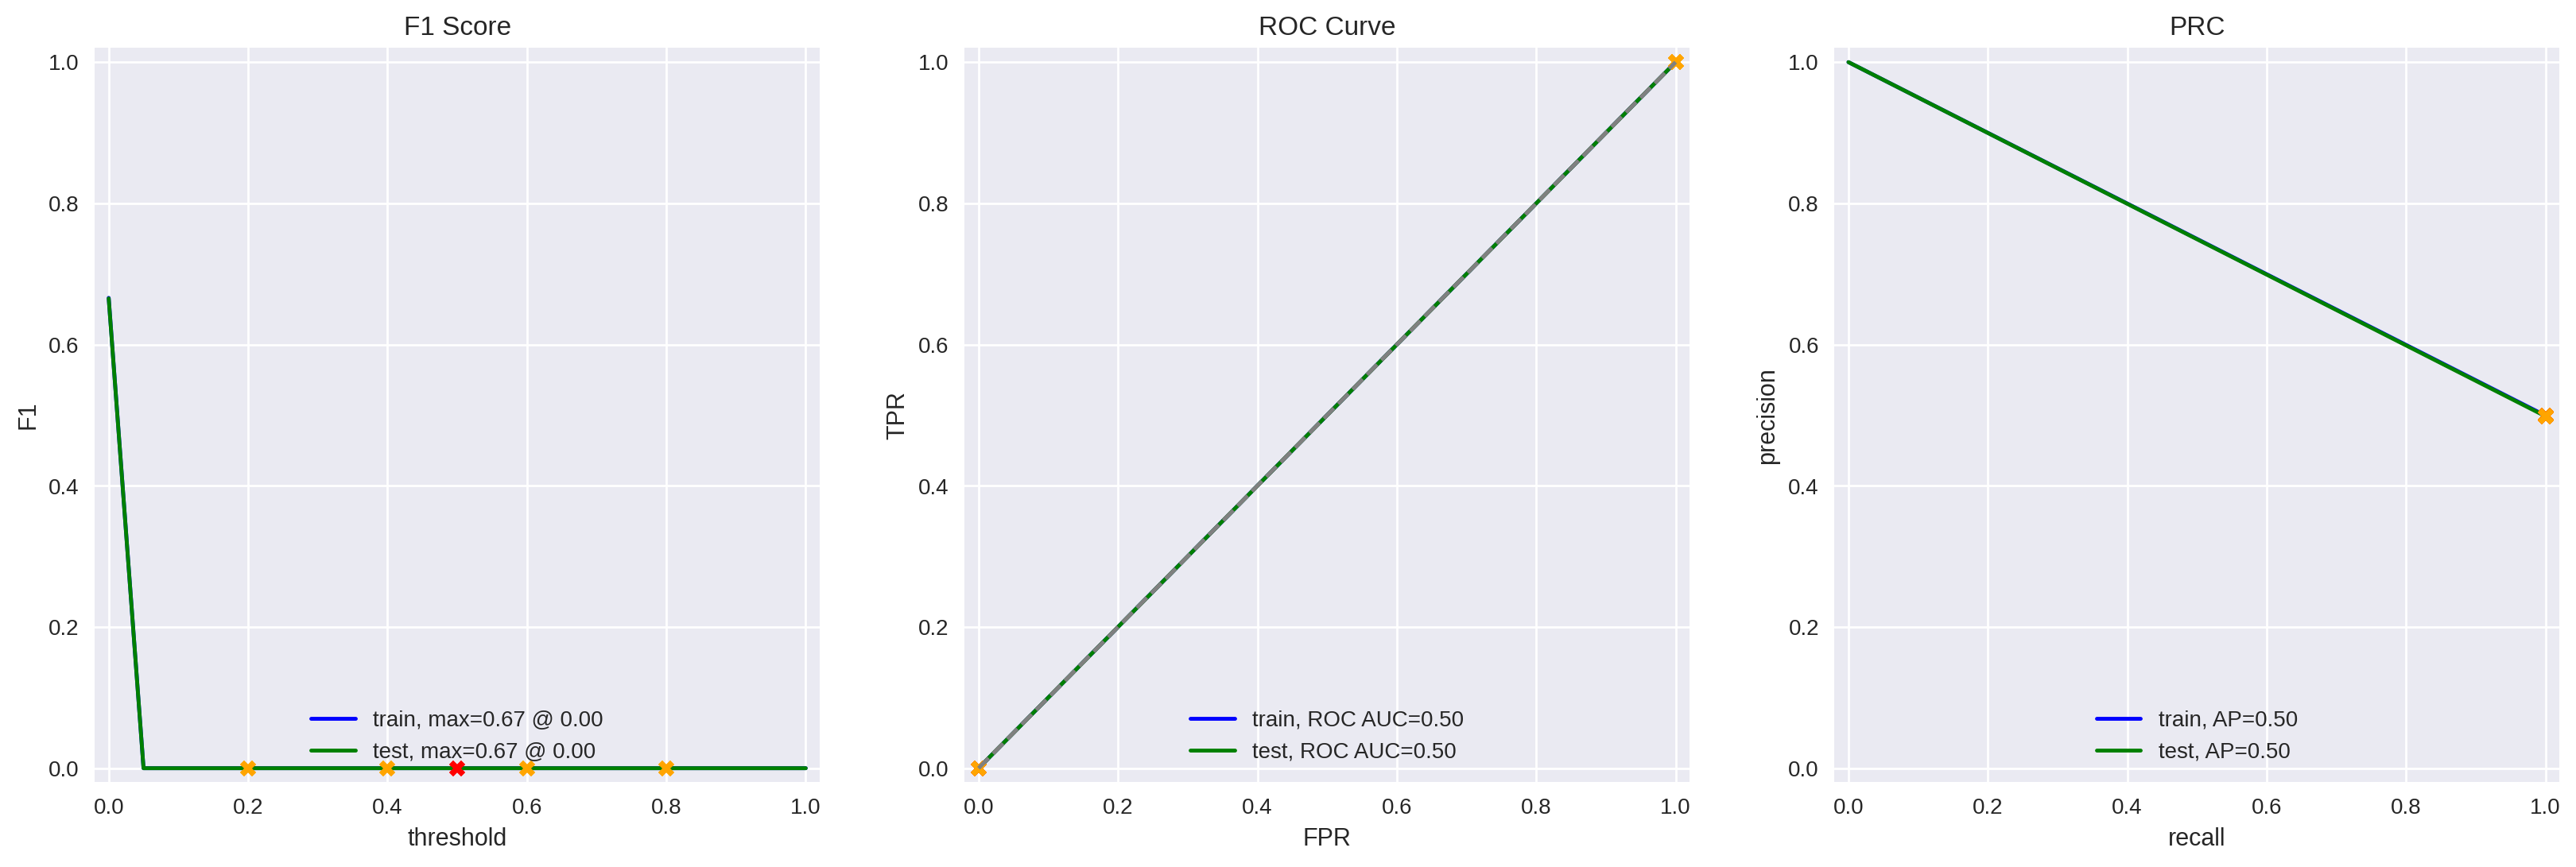

In [15]:
# Train a constant model

train_features = np.zeros((len(train_target), 1))
test_features = np.zeros((len(test_target), 1))

model_0 = DummyClassifier(strategy="most_frequent")
model_0.fit(train_features, train_target)

evaluate_model(model_0, train_features, train_target, test_features, test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [16]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [17]:
# Compute tf-idf counts

corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

stop_words = list(stopwords.words('english'))
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stop_words)

train_features_1 = tfidf_vectorizer_1.fit_transform(corpus_train)
test_features_1 = tfidf_vectorizer_1.transform(corpus_test)

print('The training TF-IDF matrix size:', train_features_1.shape)
print('The testing TF-IDF matrix size:', test_features_1.shape)

The training TF-IDF matrix size: (23796, 71531)
The testing TF-IDF matrix size: (23535, 71531)


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


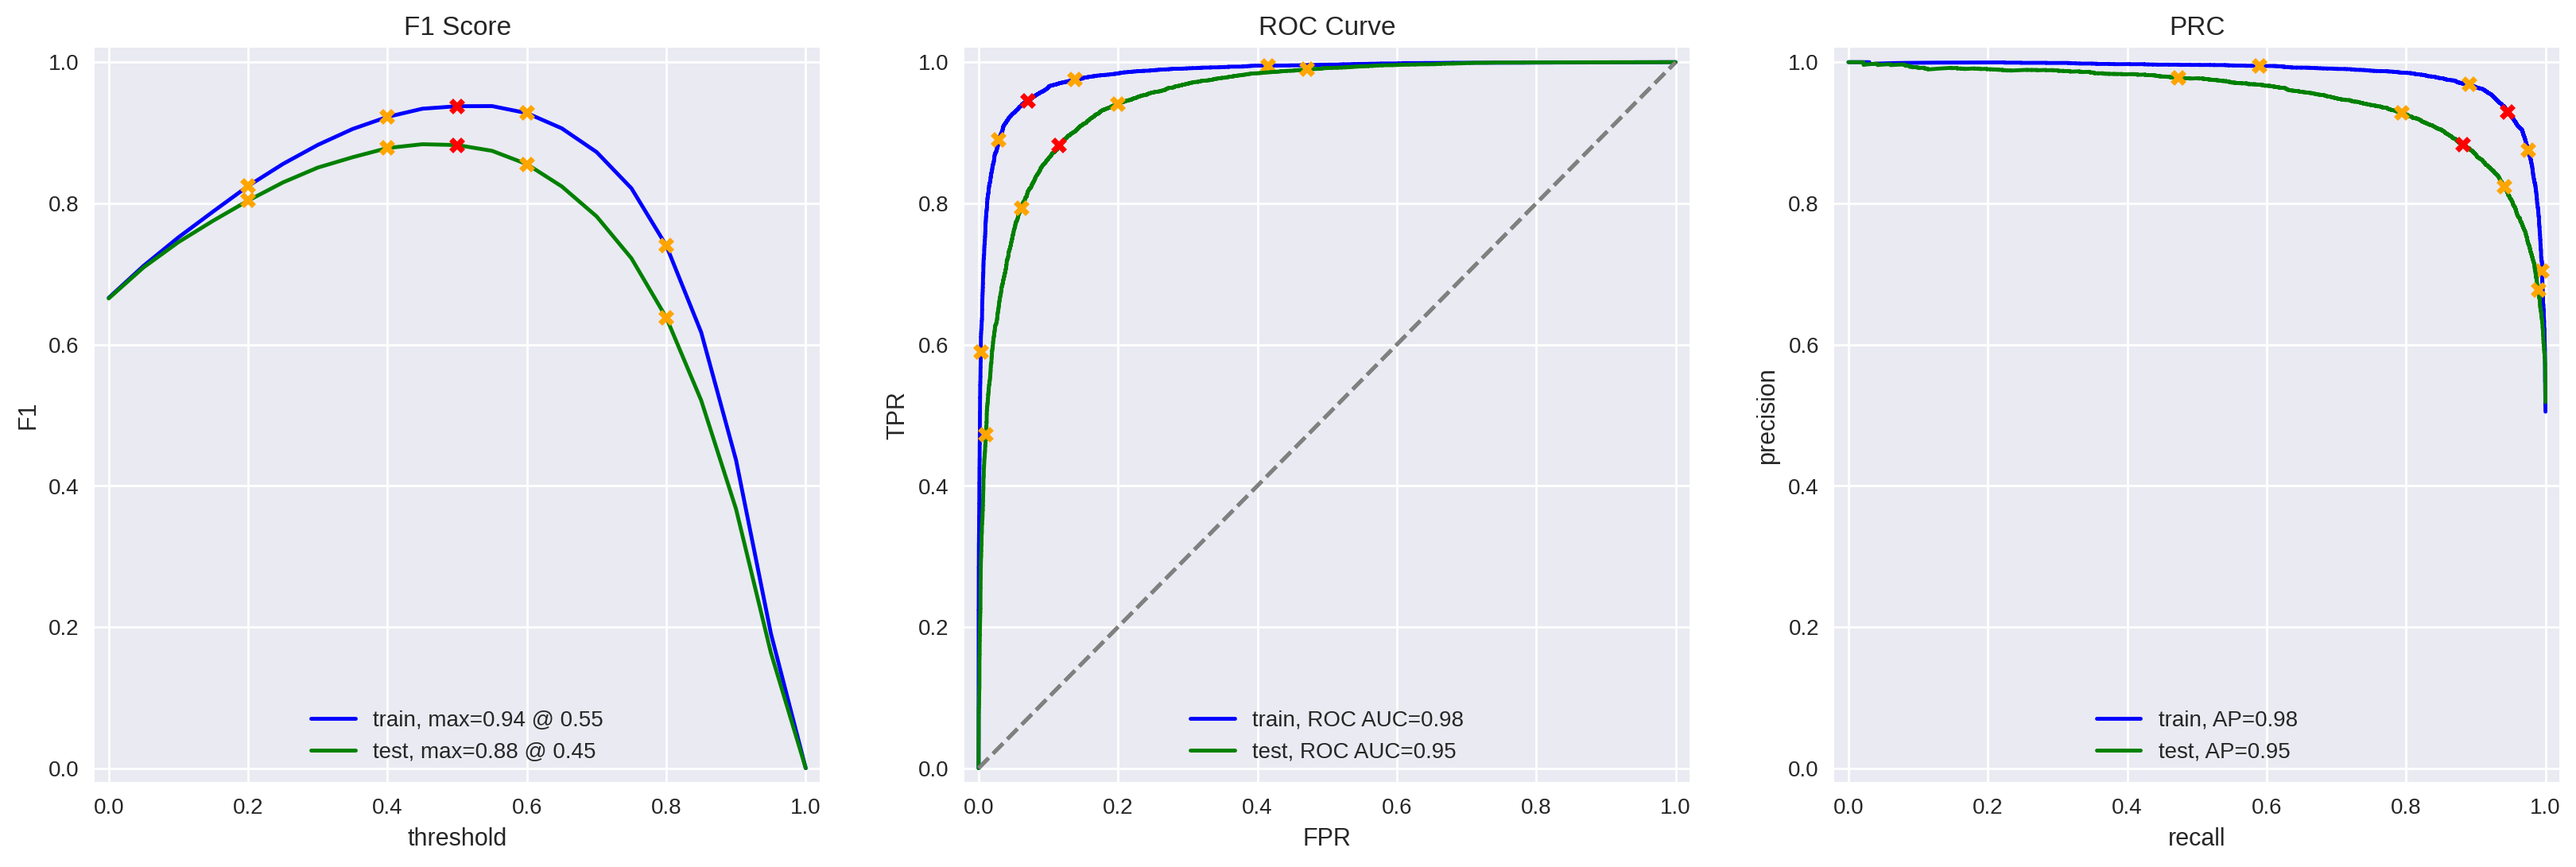

In [18]:
# Train a logistic regression model

model_1 = LogisticRegression(random_state=12345)
model_1.fit(train_features_1, train_target)

evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 2 - spaCy, TF-IDF and LR

In [19]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [20]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [21]:
# Compute tf-idf counts

corpus_train = df_reviews_train['review_norm'].apply(text_preprocessing_3)
corpus_test = df_reviews_test['review_norm'].apply(text_preprocessing_3)

stop_words = list(stopwords.words('english'))
tfidf_vectorizer_2 = TfidfVectorizer(stop_words=stop_words)

train_features_2 = tfidf_vectorizer_2.fit_transform(corpus_train)
test_features_2 = tfidf_vectorizer_2.transform(corpus_test)

print('The training TF-IDF matrix size:', train_features_2.shape)
print('The testing TF-IDF matrix size:', test_features_2.shape)

The training TF-IDF matrix size: (23796, 59139)
The testing TF-IDF matrix size: (23535, 59139)


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


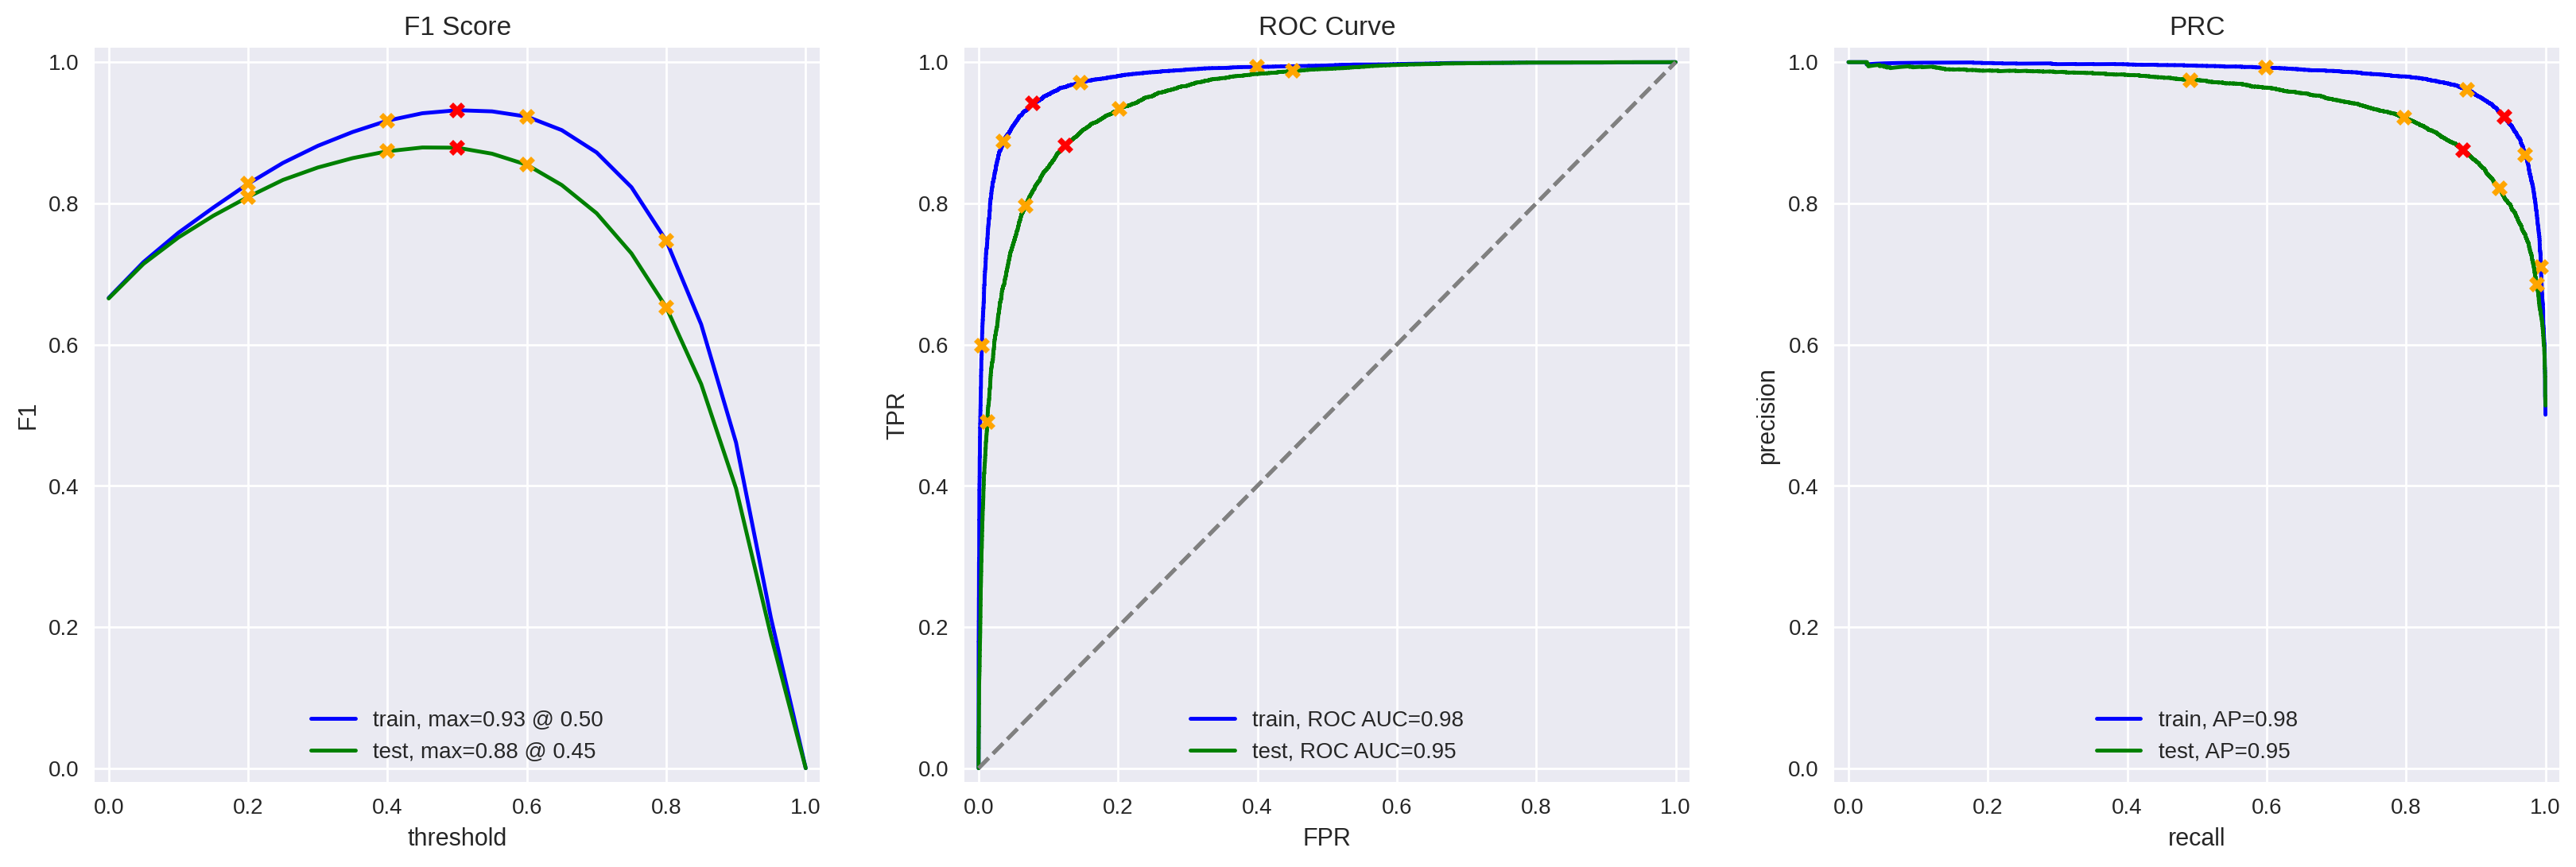

In [22]:
# Train a logistic regression model

model_2 = LogisticRegression(random_state=12345)
model_2.fit(train_features_2, train_target)

evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 3 - spaCy, TF-IDF and LGBMClassifier

In [23]:
from lightgbm import LGBMClassifier

          train  test
Accuracy   0.91  0.86
F1         0.91  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94


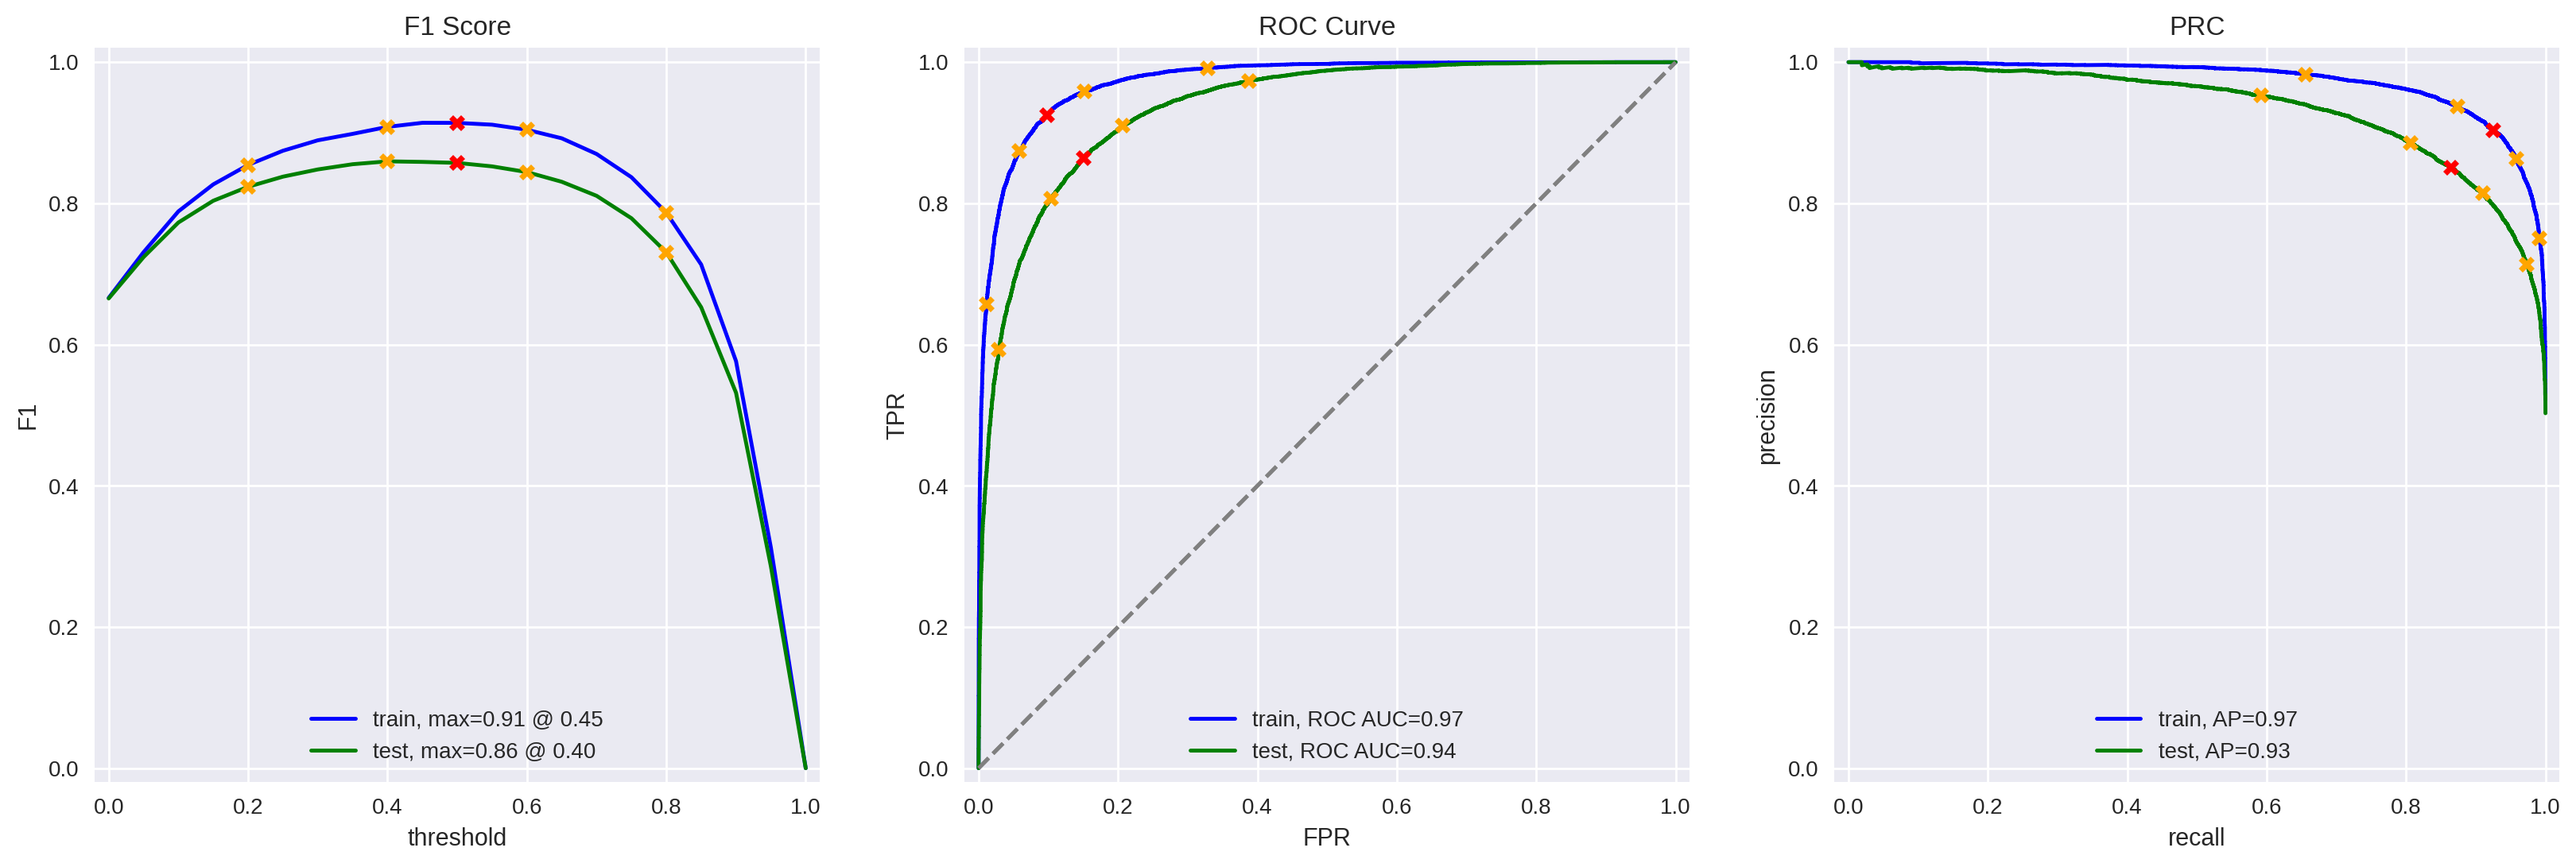

In [24]:
# Train a LGBM gradient boosted decision tree classifier model

train_features_3 = train_features_2
test_features_3 = test_features_2

model_3 = LGBMClassifier(random_state=12345)
model_3.fit(train_features_3, train_target)

evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

###  Model 9 - BERT

In [25]:
import torch
import transformers

In [26]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    for text in texts:
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0] * (max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
        
    ids_list = np.array(ids_list)
    attention_mask_list = np.array(attention_mask_list)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size * i : batch_size * (i + 1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [28]:
# Run BERT for a small subset of the data to prevent the kernel from crashing

subset_size = 50
train_BERT = df_reviews_train['review_norm'].sample(n=subset_size, random_state=12345)
test_BERT = df_reviews_test['review_norm'].sample(n=subset_size, random_state=12345)

train_features_9 = BERT_text_to_embeddings(train_BERT.tolist())
test_features_9 = BERT_text_to_embeddings(test_BERT.tolist())

train_target_9 = train_target.loc[train_BERT.index]
test_target_9 = test_target.loc[test_BERT.index]

Using the cpu device.


  0%|          | 0/1 [00:00<?, ?it/s]

Using the cpu device.


  0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(50, 768)
(23796,)


          train  test
Accuracy    1.0  0.80
F1          1.0  0.78
APS         1.0  0.89
ROC AUC     1.0  0.85


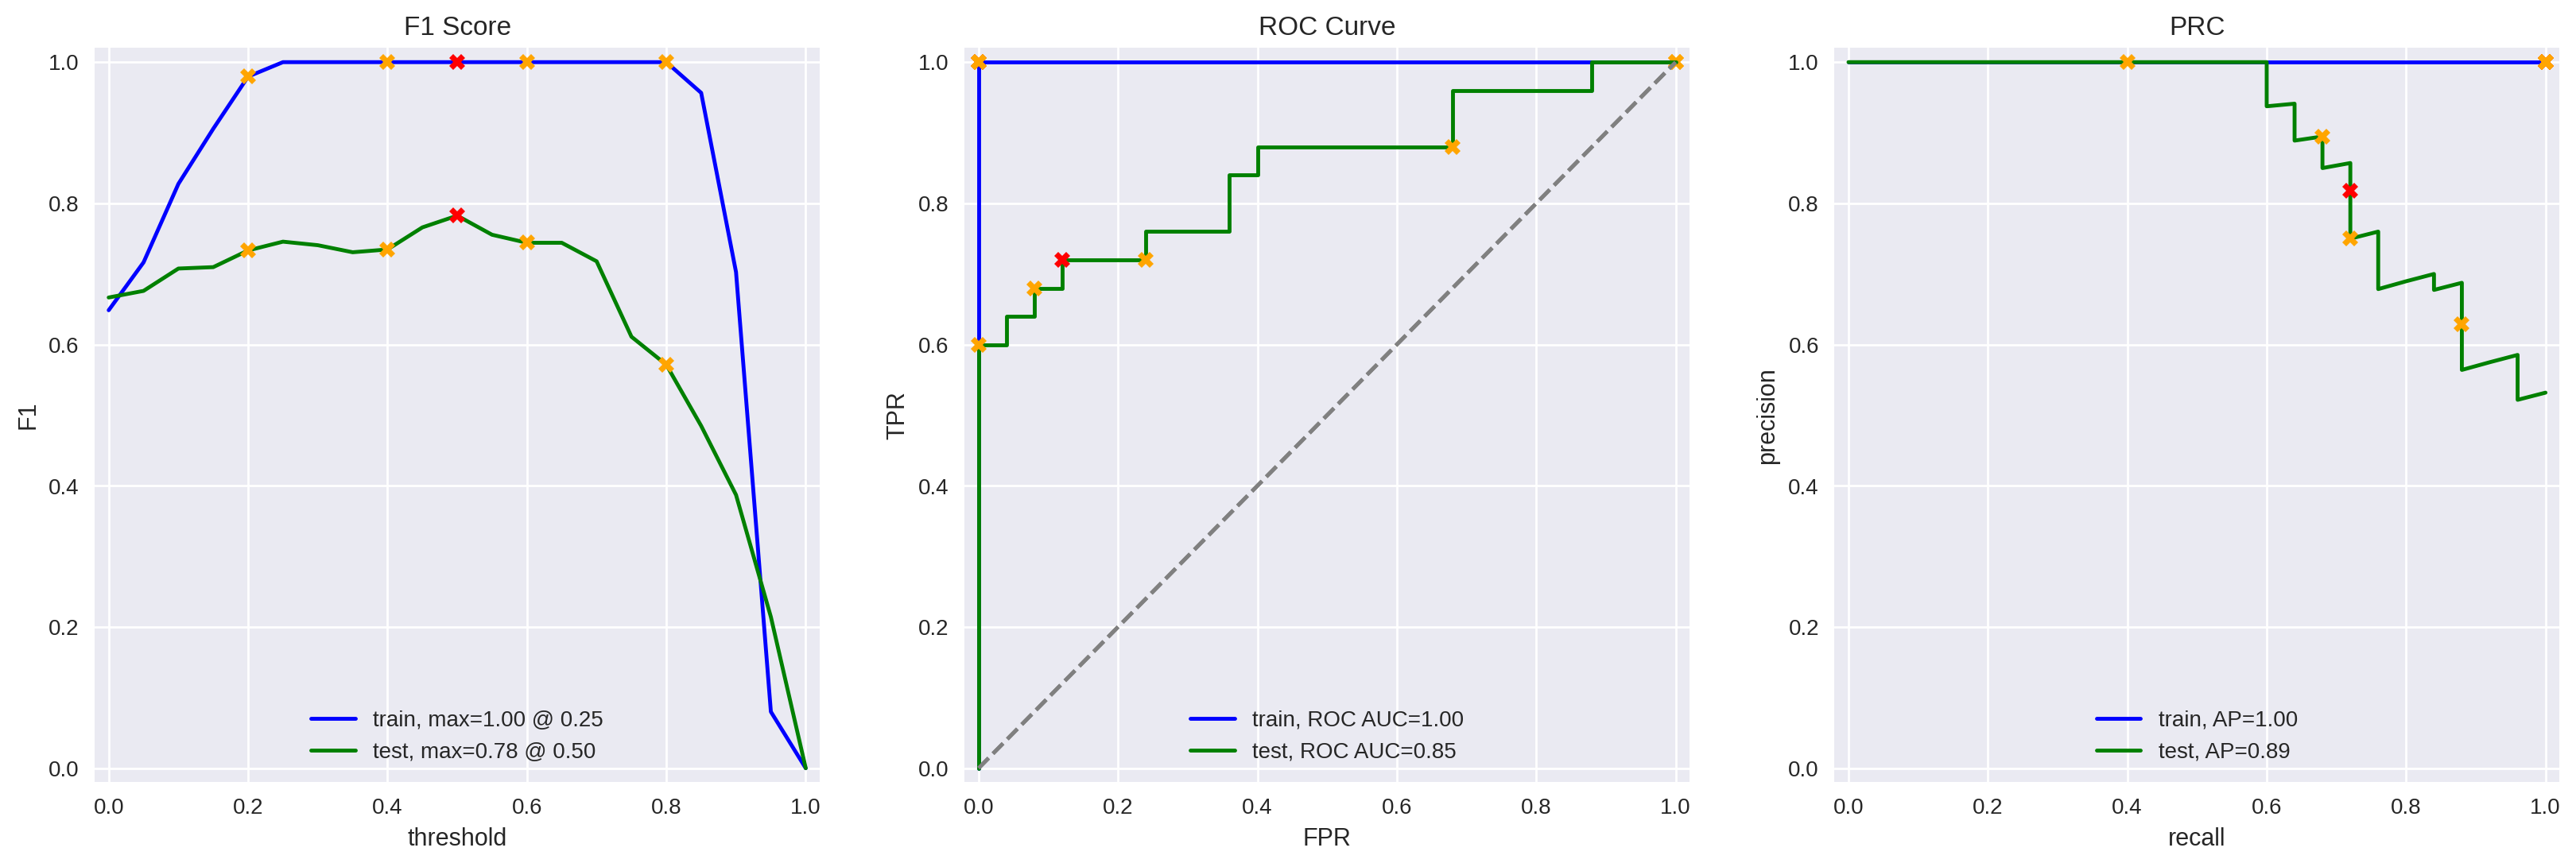

In [30]:
# Train a logistic regression model

model_9 = LogisticRegression(random_state=12345)
model_9.fit(train_features_9, train_target_9)

evaluate_model(model_9, train_features_9, train_target_9, test_features_9, test_target_9)

### Evaluate Models

In [31]:
# Compare F1 scores for Models 1 and 2 with more precision

f1_model_1 = metrics.f1_score(test_target, model_1.predict(test_features_1))
f1_model_2 = metrics.f1_score(test_target, model_2.predict(test_features_2))

print('F1 Scores:')
print(f"Model 1: {f1_model_1:.6f}")
print(f"Model 2: {f1_model_2:.6f}")
print(f"Difference: {f1_model_1 - f1_model_2:.6f}")

F1 Scores:
Model 1: 0.882586
Model 2: 0.878838
Difference: 0.003748


I ran five models. Model 0 was a dummy constant model that always predicted the most common category (in this case, negative). It was merely a sanity check. Model 1 was a logistic regression model trained on TF-IDF features with minimal preprocessing except for removing NLTK stopwords. It was a simple baseline linear model. Model 2 was a logistic regression model trained on TF-IDF features utilizing spaCy lemmatization and stopword removal. It leveraged more linguistically meaningful data. Model 3 was a LightGBM gradient-boosted decision tree classifier model trained on the same lemmatized TF-IDF features with stopword removal. It was better able to capture non-linear patterns. Model 9 was a logistic regression model trained on pretrained BERT embeddings with minimal preprocessing. It had access to richer contextual and semantic nuances. Because my computer has integrated graphics without a dedicated GPU, I had to restrict Model 9 to a very small subset of the training data with only 50 reviews (out of 23,796) to prevent the kernel from crashing. 

Model 0 had very poor scores (accuracy = 0.50, F1 = 0, APS = 0.50, and ROC AUC = 0.50). Its performance was equivalent to chance, which makes sense because it predicted negative for every review. Very nearly half of the reviews were negative, so the model was correct 50% of the time. Since it made no positive predictions, there were no true positives, resulting in an F1 score of 0. The rest of the models had substantially similar and generally good scores. Models 1 and 2 were nearly identical (accuracy = 0.88, F1 = 0.88, APS = 0.95, and ROC AUC = 0.95). Model 3 was just slightly worse on every metric (accuracy = 0.86, F1 = 0.86, APS = 0.93, and ROC AUC = 0.94). Model 9 was considerably worse on every metric (accuracy = 0.80, F1 = 0.78, APS = 0.89, and ROC AUC = 0.85). Considering its minuscule training subset, however, its performance was actually very impressive. 

APS and ROC AUC were noticeably higher for all models than Accuracy and F1. Whereas the former reflect the ability to rank observations at all possible thresholds, the latter reflect classification success at a specific threshold. The models were very good at detecting sentiment in the data and producing probability scores, but the classification thresholds, while pretty good, might not be fully optimized. Further tuning of hyperparameters and thresholds would likely increase F1 scores somewhat, but Models 1-3 all surpass the project threshold of 0.85. They are strong models that generalize well.

The plots confirmed that Model 0 had very poor performance but the plots for Models 1-3 were strikingly similar and uniformly great. The F1 Score plots showed modest optimal thresholds (between 0.40 and 0.55) for both training and testing sets (though consistently a little lower for the latter). That variation might explain the slightly lower Accuracy and F1 scores noted above. The ROC Curve plots indicated excellent discrimination power (ROC AUC of 0.94 to 0.98), distinguishing positive from negative cases far better than random guessing. The Precision-Recall Curves indicated excellent average precision (0.93 to 0.98), capturing true positives while avoiding false positives. The testing set was consistently a little worse than the training set for discrimination and precision but not by much, which suggests minimal overfitting. The plots showed Model 9 to be much better than Model 0 but clearly worse than the others. It had an optimal threshold of 0.5, ROC AUC of 0.85, and average precision of 0.89 for the testing set. The training set produced perfect F1, ROC AUC, and AP scores of 1, indicating considerable overfitting. That makes sense given how small its training set was. 

Although Models 1 and 2 had identical scores out to two decimal places, Model 1 (F1 = 0.883) just barely edged out Model 2 (F1 = 0.879). That difference is probably not significant but Model 1 was also simpler than Model 2, lacking lemmatization with spaCy. Overall, then, Model 1 was the best model for processing this review data. 

## My Reviews

In [32]:
# Train the models on my own reviews

my_reviews = pd.DataFrame([
    "This was an entertaining enough mid-range action movie. I liked the cast and the premise but found the execution a bit perfunctory.",
    "Although well-made and imaginative in some ways, this movie was kind of a mess. It felt like the filmmaker had something to say, but I don't know what.",
    "I was disappointed but still enjoyed myself. It is definitely the worst installment in an otherwise good franchise but not an embarrassment.",
    "Great cast, premise, and production! I look forward to the sequel.",
    "I hated almost everything about the movie! It was dull, disjointed, cliche, self-indulgent, and meaningless. What a waste of money!",
    "The visuals were good but the songs were uninspired and the story was forgettable.",
    "Fantastic film with stellar performances! This movie stuck with me more than most.",
    "What can I say? I got what expected. This isn't high art but I had a blast.",
    "Another triumph of tone and ambiance from one of my favorite contemporary directors. The plot itself was thin but faithful to the source material.",
    "This was pretty bad. The characters were boring and the plot didn't make any sense. I would not recommend it."
], columns=['review'])

my_reviews['review_norm'] = (my_reviews['review'].str.lower().str.replace(r"[^a-zA-Z']", ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip())

my_reviews

,review,review_norm
0,This was an entertaining enough mid-range acti...,this was an entertaining enough mid range acti...
1,Although well-made and imaginative in some way...,although well made and imaginative in some way...
2,I was disappointed but still enjoyed myself. I...,i was disappointed but still enjoyed myself it...
3,"Great cast, premise, and production! I look fo...",great cast premise and production i look forwa...
4,I hated almost everything about the movie! It ...,i hated almost everything about the movie it w...
5,The visuals were good but the songs were unins...,the visuals were good but the songs were unins...
6,Fantastic film with stellar performances! This...,fantastic film with stellar performances this ...
7,What can I say? I got what expected. This isn'...,what can i say i got what expected this isn't ...
8,Another triumph of tone and ambiance from one ...,another triumph of tone and ambiance from one ...
9,This was pretty bad. The characters were borin...,this was pretty bad the characters were boring...


### Model 1

In [33]:
texts = my_reviews['review_norm']

my_reviews_pred_prob_1 = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_1[i]:.2f}:  {review}')

0.70:  this was an entertaining enough mid range action movie i liked the cast and the premise but found th
0.36:  although well made and imaginative in some ways this movie was kind of a mess it felt like the filmm
0.23:  i was disappointed but still enjoyed myself it is definitely the worst installment in an otherwise g
0.31:  great cast premise and production i look forward to the sequel
0.01:  i hated almost everything about the movie it was dull disjointed cliche self indulgent and meaningle
0.24:  the visuals were good but the songs were uninspired and the story was forgettable
0.91:  fantastic film with stellar performances this movie stuck with me more than most
0.57:  what can i say i got what expected this isn't high art but i had a blast
0.42:  another triumph of tone and ambiance from one of my favorite contemporary directors the plot itself 
0.00:  this was pretty bad the characters were boring and the plot didn't make any sense i would not recomm


### Model 2

In [34]:
texts = my_reviews['review_norm']

my_reviews_pred_prob_2 = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_2[i]:.2f}:  {review}')

0.56:  this was an entertaining enough mid range action movie i liked the cast and the premise but found th
0.22:  although well made and imaginative in some ways this movie was kind of a mess it felt like the filmm
0.24:  i was disappointed but still enjoyed myself it is definitely the worst installment in an otherwise g
0.20:  great cast premise and production i look forward to the sequel
0.01:  i hated almost everything about the movie it was dull disjointed cliche self indulgent and meaningle
0.29:  the visuals were good but the songs were uninspired and the story was forgettable
0.90:  fantastic film with stellar performances this movie stuck with me more than most
0.62:  what can i say i got what expected this isn't high art but i had a blast
0.37:  another triumph of tone and ambiance from one of my favorite contemporary directors the plot itself 
0.01:  this was pretty bad the characters were boring and the plot didn't make any sense i would not recomm


### Model 3

In [35]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = tfidf_vectorizer_2
my_reviews_pred_prob_3 = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_3[i]:.2f}:  {review}')

0.62:  this was an entertaining enough mid range action movie i liked the cast and the premise but found th
0.36:  although well made and imaginative in some ways this movie was kind of a mess it felt like the filmm
0.34:  i was disappointed but still enjoyed myself it is definitely the worst installment in an otherwise g
0.74:  great cast premise and production i look forward to the sequel
0.04:  i hated almost everything about the movie it was dull disjointed cliche self indulgent and meaningle
0.52:  the visuals were good but the songs were uninspired and the story was forgettable
0.84:  fantastic film with stellar performances this movie stuck with me more than most
0.61:  what can i say i got what expected this isn't high art but i had a blast
0.65:  another triumph of tone and ambiance from one of my favorite contemporary directors the plot itself 
0.05:  this was pretty bad the characters were boring and the plot didn't make any sense i would not recomm


### Model 9

In [36]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob_9 = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob_9[i]:.2f}:  {review}')

0.14:  this was an entertaining enough mid range action movie i liked the cast and the premise but found th
0.05:  although well made and imaginative in some ways this movie was kind of a mess it felt like the filmm
0.06:  i was disappointed but still enjoyed myself it is definitely the worst installment in an otherwise g
0.94:  great cast premise and production i look forward to the sequel
0.25:  i hated almost everything about the movie it was dull disjointed cliche self indulgent and meaningle
0.02:  the visuals were good but the songs were uninspired and the story was forgettable
0.80:  fantastic film with stellar performances this movie stuck with me more than most
0.11:  what can i say i got what expected this isn't high art but i had a blast
0.76:  another triumph of tone and ambiance from one of my favorite contemporary directors the plot itself 
0.12:  this was pretty bad the characters were boring and the plot didn't make any sense i would not recomm


### Evaluate Models

In [37]:
# Compare models with my personal ranking

my_ranks = [5, 6, 8, 2, 10, 7, 1, 4, 3, 9]
my_reviews_results = pd.DataFrame({'my rank': my_ranks, 'model 1': my_reviews_pred_prob_1, 'model 2': my_reviews_pred_prob_2, 'model 3': my_reviews_pred_prob_3, 'model 9': my_reviews_pred_prob_9})
my_reviews_results['reviews'] = texts
my_reviews_results.sort_values(by='my rank')

,my rank,model 1,model 2,model 3,model 9,reviews
6,1,0.910300,0.895766,0.840269,0.797386,fantastic film with stellar performances this ...
3,2,0.313840,0.197722,0.740578,0.936708,great cast premise and production i look forwa...
8,3,0.422219,0.374612,0.647727,0.764127,another triumph of tone and ambiance from one ...
7,4,0.565899,0.624056,0.613666,0.107683,what can i say i got what expected this isn't ...
0,5,0.700123,0.562409,0.622869,0.136900,this was an entertaining enough mid range acti...
1,6,0.361313,0.221889,0.362437,0.047944,although well made and imaginative in some way...
5,7,0.239901,0.293317,0.519634,0.022708,the visuals were good but the songs were unins...
2,8,0.233678,0.244211,0.340693,0.063452,i was disappointed but still enjoyed myself it...
9,9,0.001267,0.005469,0.052353,0.115075,this was pretty bad the characters were boring...
4,10,0.007818,0.006831,0.037702,0.245810,i hated almost everything about the movie it w...


In [38]:
# Examine correlations and F1 scores for the models

my_target = [1, 0, 0, 1, 0, 0, 1, 1, 1, 0]

print('F1 Scores and correlations with rankings:')
for col in ['model 1', 'model 2', 'model 3', 'model 9']:
    correl = my_reviews_results['my rank'].corr(my_reviews_results[col])
    predictions = [1 if x >= 0.5 else 0 for x in my_reviews_results[col]]
    F1 = metrics.f1_score(my_target, predictions)
    print(f"{col}: Correlation = {correl:.02f}, F1 score ={F1:.02f}")

F1 Scores and correlations with rankings:
model 1: Correlation = -0.80, F1 score =0.75
model 2: Correlation = -0.74, F1 score =0.75
model 3: Correlation = -0.94, F1 score =0.91
model 9: Correlation = -0.74, F1 score =0.75


I wrote ten reviews with a range of sentiment, applied the models to them, and compared the results to my own subjective rankings.

Models 1-3 agreed on my single most positive and two most negative reviews (probabilities > 0.84 and < 0.06, respectively). Surprisingly, my second and third  most positive reviews, both quite laudatory, had lower and more variable probabilities (0.20 – 0.74 and 0.38 – 0.65, respectively) than my fourth- and fifth-ranked reviews (0.57 – 0.62 and 0.56 – 0.70, respectively), which were more mixed. The remaining reviews (ranked 6 - 8) were deemed moderately negative by all models (0.22 – 0.36, except one at 0.52). That is reasonable because while mixed, those reviews were more negative than positive.

Model 3 performed best for my reviews, tracking my subjective rankings quite closely. Its probabilities decreased almost monotonically with rank and split decisively at the correct place with the five reviews I deemed positive having probabilities above 0.61 and the five reviews I deemed negative having probabilities below 0.36 except for one outlier (0.52). Models 1 and 2 were less consistent than Model 3, correctly classifying the negative reviews but misclassifying a few of the most positive. 

Model 9 was a little different than the others. Like Model 3, it correctly identified the three most positive reviews (0.76 – 0.94), but it predicted surprisingly high probabilities for the most negative reviews (0.12 – 0.25) and very low probabilities (0.02 – 0.14) for the rest, including two positive reviews. Despite those anomalies, Model 9 correctly classified all the negative reviews and three of the positive ones. That is impressive considering its small training set. 

To evaluate the models more objectively, I calculated F1 scores for the classifications and correlations between the model-derived probabilities and my subjective rankings. The correlations were negative because low rankings are better (more positive) than high rankings. Model 3 had the best F1 Score (0.91) and correlation (-0.94), indicating a very good performance and confirming my analysis above. The other models were considerably worse but still decent (F1 = 0.75 and correlations ranging from -0.74 to -0.80), well above chance.

## Conclusions

The purpose of this project was to develop a model to automatically detect negative film reviews for the Film Junky Union with an F1 score of at least 0.85. The relevant data were appropriately formatted for modeling, the class imbalance was negligible, and the training and testing datasets were comparable. I relied exclusively on the review texts and the target (positive vs. negative). 

I trained and tested five models:

- **Model 0**: a dummy constant model  
- **Model 1**: a logistic regression model using TF-IDF features and NLTK stopwords  
- **Model 2**: a logistic regression model using TF-IDF features, spaCy lemmatization, and NLTK stopwords  
- **Model 3**: a LightGBM gradient-boosted decision tree classifier using TF-IDF features, spaCy lemmatization, and NLTK stopwords  
- **Model 9**: a logistic regression model using BERT embeddings (for a small subset of 50 reviews)

As expected, Model 0 performed very poorly (F1 = 0) and Model 9 performed modestly (F1 = 0.78) because they had restricted access to the data. Model 0 used no training data and Model 9 trained on a miniscule subset of reviews. The remaining models all performed well with Model 1 (F1 = 0.88) edging out Model 2 (F1 = 0.88) and Model 3 (F1 = 0.86). Tuning hyperparameters and thresholds might further improve F1 scores, but those three models all exceeded the project goal of 0.85. Plots confirmed that Models 1-3 were effectively equivalent with little overfitting and excellent precision and discrimination. Overall, Model 1 was the best because it was the highest-scoring and least complex of the adequate models. 

To further explore the models on an illustrative sample, I wrote ten reviews of varying positivity and applied the models to them. Models 1, 2, 3, and 9 all performed reasonably well. The model-derived probabilities correlated strongly with my subjective rankings (r ≤ -0.74) and the classifications scored reasonably well (F1 ≥ 0.75), especially considering the tiny sample size. In general, the models were better at classifying negative reviews than positive ones. Model 3 was the best model for my reviews (r = -0.94, F1 = 0.91), far outperforming the others and misclassifying only one review. 

It is curious that different models were best for the full corpus and my personal reviews. Model 3 is more complex, capturing non-linear dynamics and feature interactions that Model 1 cannot. My personal reviews may be more nuanced and equivocal than most reviews in the corpus. My writing style tends toward complexity and qualification instead of strong, categorical statements. That might explain why Model 3 was clearly better for my reviews but slightly worse than Model 1 for the full corpus. Writing style matters for sentiment analysis and model performance probably reflects my idiosyncrasies. The full corpus much better represents reviews of interest to the Film Junky Union than my small personal sample. 

In conclusion, I recommend that the Film Junky Union adopt Model 1 because it best balances performance and complexity for the full corpus. 

# Checklist

- [x]  Notebook was opened
- [x]  The text data is loaded and pre-processed for vectorization
- [x]  The text data is transformed to vectors
- [x]  Models are trained and tested
- [x]  The metric's threshold is reached
- [x]  All the code cells are arranged in the order of their execution
- [x]  All the code cells can be executed without errors
- [x]  There are conclusions